# Statistical models in R
This notebook is covering:
1. Data preprocessing:
    1. Aligning all dataframe to 5-day week from 2018-10-01 to 2024-08-30.
    2. Interpolating missing values.
2. ARMA-models.

In [24]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go

In [25]:
# rpy2 is a Python package that allows you to run R code from Python
%pip install rpy2

Note: you may need to restart the kernel to use updated packages.


In [26]:
# Load the rpy2 extension to use R in Jupyter
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


The magic function `%%R` is used for running R code in Jupyter

In [27]:
%%R
# Install required packages
if (require("dplyr") == FALSE) {
  install.packages("dplyr")
  library(dplyr)
}
if (require("zoo") == FALSE) {
  install.packages("zoo")
  library(zoo)
}
if (require("psych") == FALSE) {
  install.packages("psych")
  library(psych)
}
if (require("TSA") == FALSE) {
  install.packages("TSA")
  library(TSA)
}
if (require("forecast") == FALSE) {
  install.packages("forecast")
  library(forecast)
}
if (require("Metrics") == FALSE) {
  install.packages("Metrics")
  library(Metrics)
}
if (require("ggplot2") == FALSE) {
  install.packages("ggplot2")
  library(ggplot2)
}
if (require("vars") == FALSE) {
  install.packages("vars")
  library(vars)
}
if (require("svars") == FALSE) {
  install.packages("svars")
  library(svars)
}
if (require("tsDyn") == FALSE) {
  install.packages("tsDyn")
  library(tsDyn)
}


In [28]:
%%R
# Load data
hub_prices <- list(
  nbp = read.csv("../data/interpolated/nbp_close_interpolated.csv"),
  peg = read.csv("../data/interpolated/peg_close_interpolated.csv"),
  the = read.csv("../data/interpolated/the_close_interpolated.csv"),
  ttf = read.csv("../data/interpolated/ttf_close_interpolated.csv"),
  ztp = read.csv("../data/interpolated/ztp_close_interpolated.csv")
)

In [29]:
%%R

hub1_name <- "ttf"
hub2_name <- "nbp"

hub1 <- hub_prices[[hub1_name]]
hub2 <- hub_prices[[hub2_name]]

hubs <- data.frame(hub1 = hub1$CLOSE, hub2 = hub2$CLOSE)


In [30]:
%%R
horizon <- 250
window_size <- 5
train_size <- nrow(hubs) - horizon - window_size
hub_train <- hubs[1:train_size+1, ]

In [31]:
%%R
aics <- c()
bics <- c()
max_lag <- 20
for (p in 1:max_lag) {
  vecm <- VECM(hub_train, lag = p,  r = 1, include = "both", estim = "ML")
  aics <- c(aics, AIC(vecm))
  bics <- c(bics, BIC(vecm))
}

[1] 20


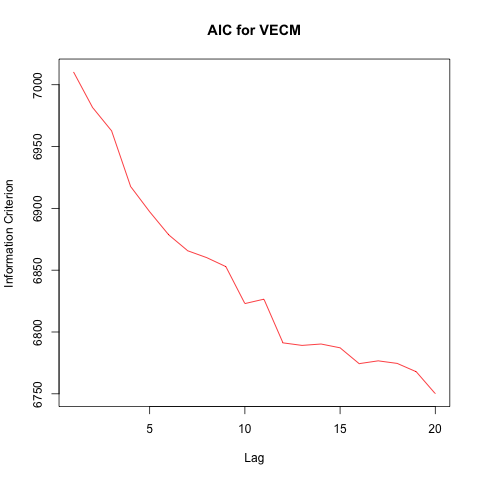

In [32]:
%%R
aic_lags <- which.min(aics)
print(aic_lags)
plot(1:max_lag, aics, type = "l", col = "red", xlab = "Lag", ylab = "Information Criterion", main = "AIC for VECM")

[1] 4


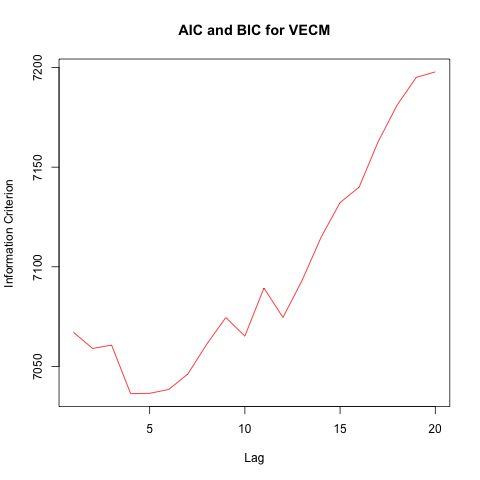

In [33]:
%%R
bic_lags <- which.min(bics)
print(bic_lags)
plot(1:max_lag, bics, type = "l", col = "red", xlab = "Lag", ylab = "Information Criterion", main = "AIC and BIC for VECM")

In [34]:
%%R
vecm <- VECM(hub_train, lag = bic_lags,  r = 1, include = "const", estim = "ML")
end_sample_actuals <- tail(hub_train, -(bic_lags + 1))
in_sample_prediction <- end_sample_actuals - residuals(vecm)
colnames(end_sample_actuals) <- c(hub1_name, hub2_name)
colnames(in_sample_prediction) <- c(hub1_name, hub2_name)

In [35]:
%%R
hub1_mae <- round(Metrics::mae(end_sample_actuals[[hub1_name]], in_sample_prediction[[hub1_name]]), 2)
hub2_mae <- round(Metrics::mae(end_sample_actuals[[hub2_name]], in_sample_prediction[[hub2_name]]), 2)
print(paste("MAE for", hub1_name, ":", hub1_mae))
print(paste("MAE for", hub2_name, ":", hub2_mae))

[1] "MAE for ttf : 2.56"
[1] "MAE for nbp : 2.74"


In [36]:
%%R
summary(vecm)

#############
###Model VECM 
#############
Full sample size: 1290 	End sample size: 1285
Number of variables: 2 	Number of estimated slope parameters 20
AIC 6916.258 	BIC 7024.587 	SSR 89038.47
Cointegrating vector (estimated by ML):
   hub1      hub2
r1    1 -1.401555


              ECT               Intercept          hub1 -1          
Equation hub1 0.0256(0.0116)*   0.3016(0.2111)     0.2282(0.0661)***
Equation hub2 0.0428(0.0119)*** 0.4989(0.2158)*    0.2946(0.0675)***
              hub2 -1             hub1 -2            hub2 -2           
Equation hub1 -0.0928(0.0648)     -0.1818(0.0665)**  0.0636(0.0650)    
Equation hub2 -0.1705(0.0662)*    -0.2346(0.0680)*** 0.1159(0.0664).   
              hub1 -3            hub2 -3           hub1 -4          
Equation hub1 -0.2822(0.0668)*** 0.2835(0.0650)*** 0.1487(0.0668)*  
Equation hub2 -0.3106(0.0682)*** 0.2929(0.0664)*** 0.2533(0.0683)***
              hub2 -4            
Equation hub1 -0.0143(0.0650)    
Equation hub2 -0.1503(0.0665)*

In [37]:
%%R
beta <- (-1)*vecm$model.specific$beta[2, 1]

In [38]:
%%R
beta

[1] 1.401555


In [16]:
%%R
str(vecm)

List of 19
 $ residuals     : num [1:1284, 1:2] -0.814 -0.364 0.884 -0.524 -0.25 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:1284] "8" "9" "10" "11" ...
  .. ..$ : chr [1:2] "hub1" "hub2"
 $ coefficients  : num [1:2, 1:12] 0.588 0.768 0.148 0.192 -1.17 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:2] "Equation hub1" "Equation hub2"
  .. ..$ : chr [1:12] "ECT" "Intercept" "hub1 -1" "hub2 -1" ...
 $ k             : int 2
 $ t             : num 1284
 $ T             : int 1290
 $ npar          : int 24
 $ nparB         : int 12
 $ type          : chr "linear"
 $ fitted.values : num [1:1284, 1:2] 0.1987 -0.0967 -0.0148 0.5209 -0.0468 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:1284] "8" "9" "10" "11" ...
  .. ..$ : chr [1:2] "hub1" "hub2"
 $ model.x       : num [1:1284, 1:12] -0.0641 -0.0415 -0.0504 -0.0147 -0.0755 ...
 $ include       : chr "const"
 $ lag           : int 5
 $ model         :'data.frame':	1290 obs. of  14 variables:
  ..$ hub1     : 

In [14]:
%%R

hub1_train_dates <- hub1[1:train_size+1, ]$Date
end_sample_dates <- tail(hub1_train_dates, -(bic_lags + 1 ))
in_sample_prediction <- cbind(data.frame(Date = end_sample_dates), in_sample_prediction)


In [15]:
%%R
write.csv(in_sample_prediction, paste0("../../predictions/in_sample/is_",hub1_name,"_", hub2_name, "_h", horizon, "_w", window_size, "_vecm_predictions.csv"), row.names = FALSE)

Error in file(file, ifelse(append, "a", "w")) : 
  cannot open the connection
In addition: Warning message:
In file(file, ifelse(append, "a", "w")) :
  cannot open file '../../predictions/in_sample/is_ttf_the_h250_w5_vecm_predictions.csv': No such file or directory
Error in file(file, ifelse(append, "a", "w")) : 
  cannot open the connection


RInterpreterError: Failed to parse and evaluate line 'write.csv(in_sample_prediction, paste0("../../predictions/in_sample/is_",hub1_name,"_", hub2_name, "_h", horizon, "_w", window_size, "_vecm_predictions.csv"), row.names = FALSE)\n'.
R error message: 'Error in file(file, ifelse(append, "a", "w")) : \n  cannot open the connection'
R stdout:
Error in file(file, ifelse(append, "a", "w")) : 
  cannot open the connection
In addition: Warning message:
In file(file, ifelse(append, "a", "w")) :
  cannot open file '../../predictions/in_sample/is_ttf_the_h250_w5_vecm_predictions.csv': No such file or directory

In [198]:
%%R
vecm_predictions <- function(hubs, window_size = 5, horizon = 250) {
  
  # Initialize empty data frames for storing predictions and actual values
  predictions <- data.frame(matrix(ncol = ncol(hubs), nrow = 0))
  actuals <- data.frame(matrix(ncol = ncol(hubs), nrow = 0))
  
  colnames(predictions) <- colnames(hubs)
  colnames(actuals) <- colnames(hubs)
  
  for (i in 1:horizon) {
    train_size <- nrow(hubs) - horizon - window_size + i
    hub_train <- hubs[1:train_size, ]
    
    # Fit the VECM model
    vecm <- VECM(hub_train, lag = bic_lags, r = 1, include = "both", estim = "ML")
    
    # Predict the future values
    hub_forecast <- predict(vecm, n.ahead = window_size)
    
    hub_prediction <- hub_forecast[window_size, , drop = FALSE]
    
    hub_actual <- hubs[train_size + window_size, ]
    
    predictions <- rbind(predictions, hub_prediction)
    actuals <- rbind(actuals, hub_actual)
  }
  
  # Return both data frames as a list
  return(list(predictions = predictions, actuals = actuals))
}
  

In [199]:
%%R
horizon <- 250
window_size <- 5
vecm_output <- vecm_predictions(hubs, window_size = window_size, horizon = horizon)
hub1_predictions <- vecm_output$predictions$hub1
hub1_actuals <- vecm_output$actuals$hub1
hub2_predictions <- vecm_output$predictions$hub2
hub2_actuals <- vecm_output$actuals$hub2

hub1_mae <- mae(hub1_actuals, hub1_predictions)
hub2_mae <- mae(hub2_actuals, hub2_predictions)

hub1_rmse <- rmse(hub1_actuals, hub1_predictions)
hub2_rmse <- rmse(hub2_actuals, hub2_predictions)
print(paste0("Pair: ", hub1_name, " | ", hub2_name))
print(paste0("Window Size: ", window_size))
print(paste0("Horizon: ", horizon))
print(paste0(hub1_name,": Mean Absolute Error: ", hub1_mae))
print(paste0(hub1_name,": Root Mean Squared Error: ", hub1_rmse))

print(paste0(hub2_name,": Mean Absolute Error: ", hub2_mae))
print(paste0(hub2_name,": Root Mean Squared Error: ", hub2_rmse))

[1] "Pair: ttf | the"
[1] "Window Size: 5"
[1] "Horizon: 250"
[1] "ttf: Mean Absolute Error: 2.15439601058386"
[1] "ttf: Root Mean Squared Error: 3.00820138609321"
[1] "the: Mean Absolute Error: 2.15991921119847"
[1] "the: Root Mean Squared Error: 2.86994087281757"


In [200]:
%%R
predictions <- vecm_output$predictions
actuals <- vecm_output$actuals

colnames(predictions) <- c(hub1_name, hub2_name)
colnames(actuals) <- c(hub1_name, hub2_name)

In [201]:
%%R

prediction_dates = tail(hub1$Date, horizon)

predictions <- cbind(data.frame(Date = prediction_dates), predictions)

actuals <- cbind(data.frame(Date = prediction_dates), actuals)

In [202]:
%%R
write.csv(predictions, paste0("../../predictions/out_of_sample/",hub1_name,"_", hub2_name, "_h", horizon, "_w", window_size, "_vecm_predictions.csv"), row.names = FALSE)

In [203]:
%%R
hub1_forecast_comparison <- data.frame(
  Actual = hub1_actuals,
  Forecasted = hub1_predictions
)

In [204]:
%R -o hub1_forecast_comparison
%R -o hub1_name

hub1_forecast_comparison = hub1_forecast_comparison

actual_trace = go.Scatter(
    x=hub1_forecast_comparison.index,
    y=hub1_forecast_comparison['Actual'],
    mode='lines',
    name='Actual Prices'
)

forecasted_trace = go.Scatter(
    x=hub1_forecast_comparison.index,
    y=hub1_forecast_comparison['Forecasted'],
    mode='lines',
    name='Forecasted Prices'
)

# Create the plot
layout = go.Layout(
    title= hub1_name.item() + ': VECM Actual vs Forecasted Prices',
    xaxis=dict(title='Index'),
    yaxis=dict(title='Price'),
)

fig = go.Figure(data=[actual_trace, forecasted_trace], layout=layout)
fig.show()


In [205]:
%%R
hub2_forecast_comparison <- data.frame(
  Actual = hub2_actuals,
  Forecasted = hub2_predictions
)

In [206]:
%R -o hub2_forecast_comparison
%R -o hub2_name

hub2_forecast_comparison = hub2_forecast_comparison

actual_trace = go.Scatter(
    x=hub2_forecast_comparison.index,
    y=hub2_forecast_comparison['Actual'],
    mode='lines',
    name='Actual Prices'
)

forecasted_trace = go.Scatter(
    x=hub2_forecast_comparison.index,
    y=hub2_forecast_comparison['Forecasted'],
    mode='lines',
    name='Forecasted Prices'
)

# Create the plot
layout = go.Layout(
    title= hub2_name.item() + ': VECM Actual vs Forecasted Prices',
    xaxis=dict(title='Index'),
    yaxis=dict(title='Price'),
)

fig = go.Figure(data=[actual_trace, forecasted_trace], layout=layout)
fig.show()
